## Biblioteki i dane

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import itertools
import statsmodels.api as sm
from tqdm import tqdm
import pickle
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from scipy.stats import jarque_bera

In [ ]:
dfo = pd.read_csv('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AEP_hourly.csv')
dfo['Datetime'] = pd.to_datetime(dfo['Datetime'])

## Wstęp

Celem projektu jest analiza oraz prognoza zużycia energii elektrycznej na podstawie danych zebranych przez PJM Interconnection LLC. Dane te obejmują godzinowe zużycie energii w różnych regionach USA. Zaczniemy od analizy danych pod względem występowania trendu oraz sezonowości. Nastepnie dobierzemy odpowiednie modele oraz wykonamy prognozy zużycia energii.

Celem biznesowym na który projekt ma odpowiadać jest minimalizacja ryzyka przepalenie się sieci przesyłowej. Może ono wystąpić gdy faktyczne zużycie energii jest mniejsze niż przywidywane i gdy nie ma gdzie tej energii wysłać (i.e. przy większych odchyleniach od przewidywać ryzyko to rośnie). Z tego powodu do błędu prognozy użyjemy metryk, które penalizują mocniej duże odchylenia oraz penalizują asymetrycznie.

## Wstępna analiza danych

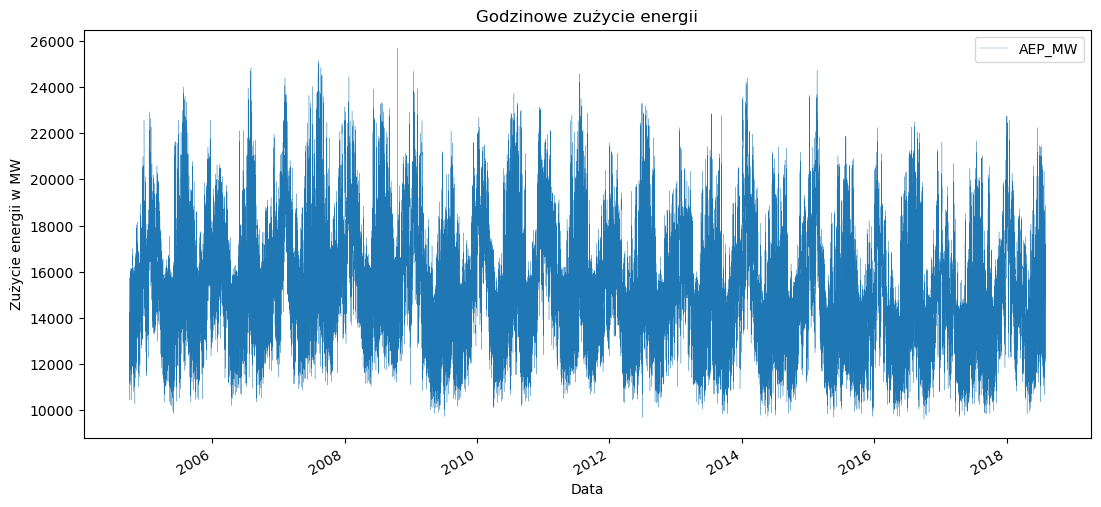

In [ ]:
dfo.set_index('Datetime').plot(figsize = (13,6), linewidth=0.2, title = 'Godzinowe zużycie energii')
plt.xlabel('Data')
plt.ylabel('Zużycie energii w MW')
plt.show()

Zaczniemy od przyjrzenia się wykresowi danych godzinowych. Od razu widzimy, że w danych występuje sezonowość roczna. Trend nie jest zbyt wyraźny, średni poziom zużycia energii wydaje się raczej stały na przestrzeni lat. Z racji na dużą ilośc danych oraz to, że sezonowości są długoterminowe a dane są godzinowe przeprowadzimy agregację na dwa poziomy - dzienny i tygodniowy. Ułatwi to dobór odpowiednich modeli.

## Agregacja tygodniowa

In [ ]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='W')).sum()
df.sort_index(inplace = True)

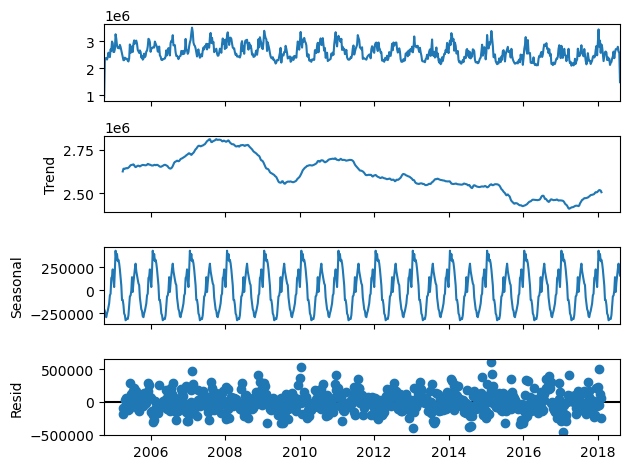

In [ ]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 52)
decomp_a.plot()
plt.show()

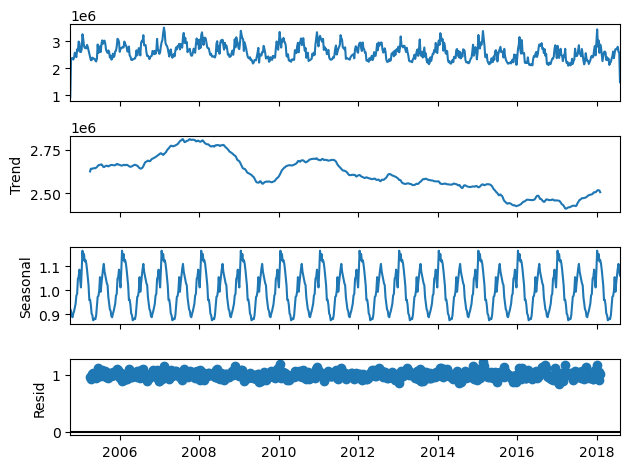

In [ ]:
decomp_a = seasonal_decompose(df, model = 'multiplicative', period = 52)
decomp_a.plot()
plt.show()

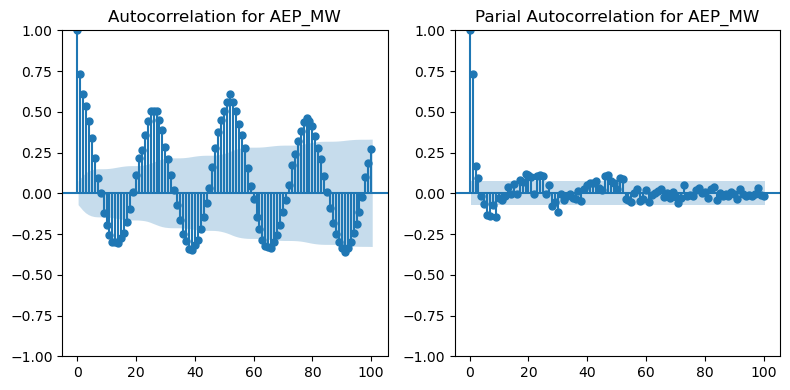

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=100, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=100, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW")

plt.tight_layout()
plt.show()

Dekompozycja oraz wartości funkcji autokorelacji potwierdziły nasze przypuszczenia o mocnej sezonowości. ACF przyjmuje szczyty co około 13 opóźnień, co może sugerować sezonowość kwartalną. Dodatkowo wartości bardzo powoli zanikają, co może sugerować pewien trend. Funkcja cząstkowej autokorelacji przyjmuje największe wartości na pierwszym opóźnieniu, więc możliwe że w doborze odelu SARIMA nie będziemy potrzebowali zbyt dużych opóźnień.

Dalszą analizę będziemy przeprowadzać na danych oryginalnych oraz zlogarytmowanych, które następnie zrożnicujemy z krokami 1 oraz 52. Pomoże to wyeliminować (potencjalny) trend i niestacjonarność. Dodatkowo różnice logarytmów można interpretować jako stopy wzrostu w skali logarytmicznej (gdyby dane były finansowe to mówilibyśmy o stopie zwrotu przy kapitalizacji ciągłej). Dane po takiej transformacji mogą lepiej opisywać dynamikę (względne różnice) zużycia energii między kolejnymi okresami.

In [ ]:
dfm = df.copy()
dfm['AEP_MW_ln'] = np.log(dfm['AEP_MW'])
dfd = dfm.diff(1).diff(52)
dfd = dfd.dropna()

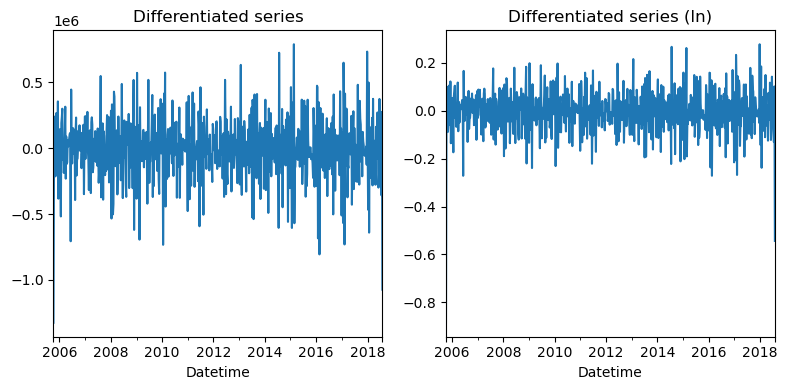

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0])
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

Szereg po zróżnicowaniu o wiele bardziej przypomina szereg stacjonarny. Widzimy, że wartość oczekiwana jest stała oraz wydaje się, że wariancja jest niezmiennicza na przesunięcia. Przypuszczenie o stacjonarności potwierdzimy testem ADF, którego hipoteza zerowa mówi o występowaniu tzw. unit root'u - czyli inaczej H0: Szereg nie jest stacjonarny.

In [ ]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-value szeregu {adt1[1]}, p-value szeregu ln {adt2[1]}")

p-value szeregu 3.6978756890071637e-23, p-value szeregu ln 1.8725339365726934e-22


P-value obydwu szeregów jest praktycznie zerowe, co potwierdza nasze przypuszczenia - szeregi po transformacji są stacjonarne. Następnie sprawdzimy autokorelacje.

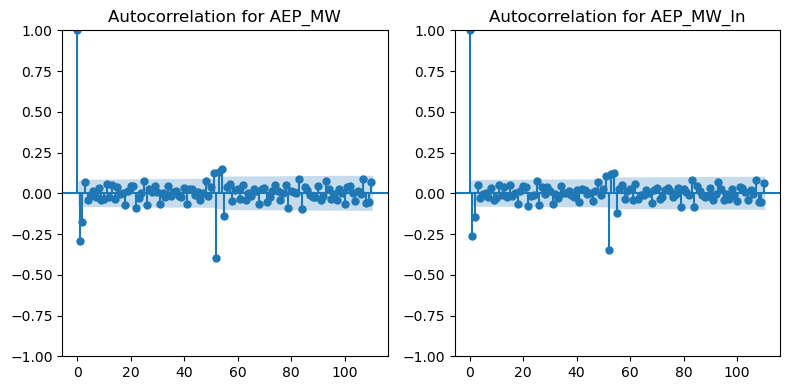

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

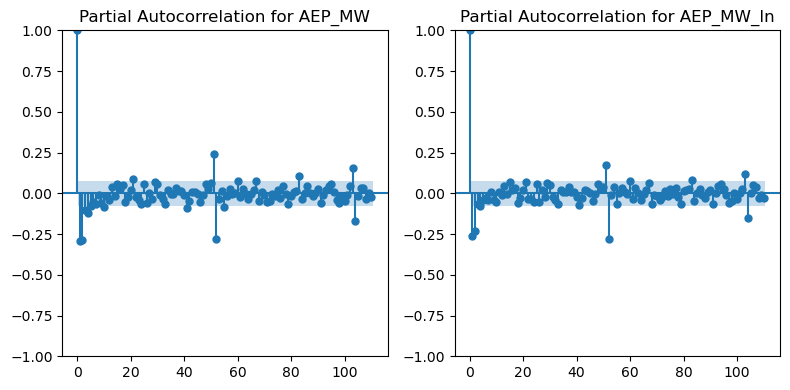

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Wartości ACF oraz PACF są największe dla opóźnieni 1, 2 oraz dla wielokrotności 52 i 53. Korzystając z tej informacji dobierzemy modele SARIMA z $p,q,P,Q = 1, 2$ oraz z $i, I = 1$. Dla każdego z nich policzymy AIC oraz BIC i do następnego etapu wybierzemy tylko modele z najmniejszymi wartościami kryteriów informacyjnych.

In [ ]:
data_train = dfm.loc['2005-01-01':'2017-12-31', :]
data_test = dfm.loc['2018-01-01':'2018-06-30', :]

In [ ]:
dfL = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC1.pkl')
dfL2 = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC2.pkl')

In [ ]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])
df_IC.reset_index(drop = True, inplace= True)
df_IC.index = ['Dane oryginalne', 'Dane oryginalne', 'Logarytm', 'Logarytm']

In [ ]:
df_IC

,p,q,P,Q,AIC,BIC
Dane oryginalne,0,2,0,2,16927.820099,16950.016851
Dane oryginalne,0,2,0,1,16929.476180,16947.233581
Logarytm,1,1,1,2,16945.164859,16971.800961
Logarytm,1,1,1,2,16945.164859,16971.800961


Widzimy, że dla danych zlogarytmowanych w obydwu kryteriach dostaliśmy ten sam model, natomiast w przypadku danych oryginalnych inny model miał najlepsze AIC a inny BIC. Przeanalizujemy teraz reszty tych modeli - sprawdzimy ich normalnośc oraz niezależność

In [ ]:
with open('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/models.pkl', "rb") as f:
    models = pickle.load(f)

with open('models.pkl', 'wb') as f:


In [ ]:
model_names = ['SARIMA(0,1,2,0,1,2,52)', 'SARIMA(0,1,2,0,1,1,52)', 'SARIMA(1,1,1,1,1,2,52) log']

In [ ]:
resid_list = []
for i in range(3):
    model_fit = models[i]
    if i < 2:
        resid = model_fit.resid
    else:
        resid = np.exp(model_fit.resid[1:])
    resid_list.append(resid)

SARIMA(0,1,2,0,1,2,52) 



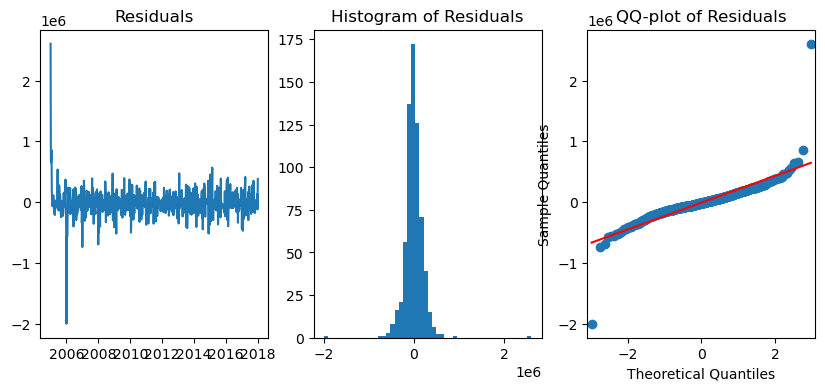

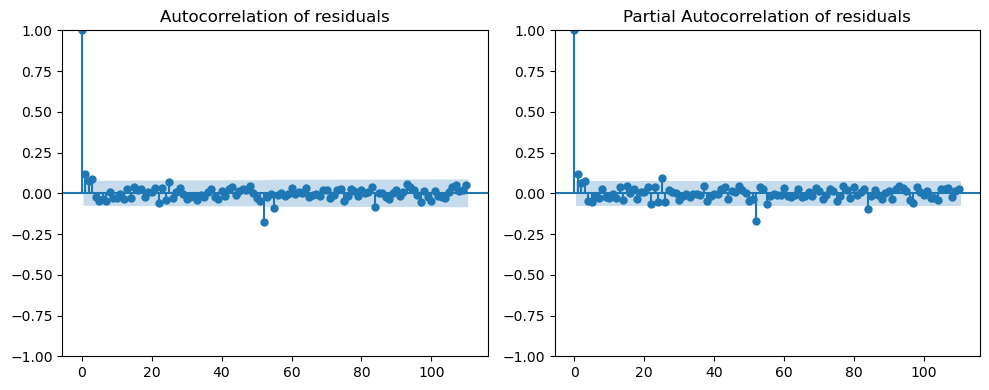

SARIMA(0,1,2,0,1,1,52) 



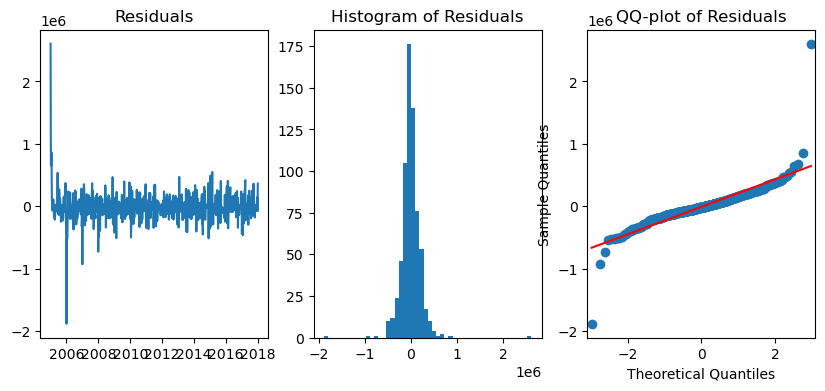

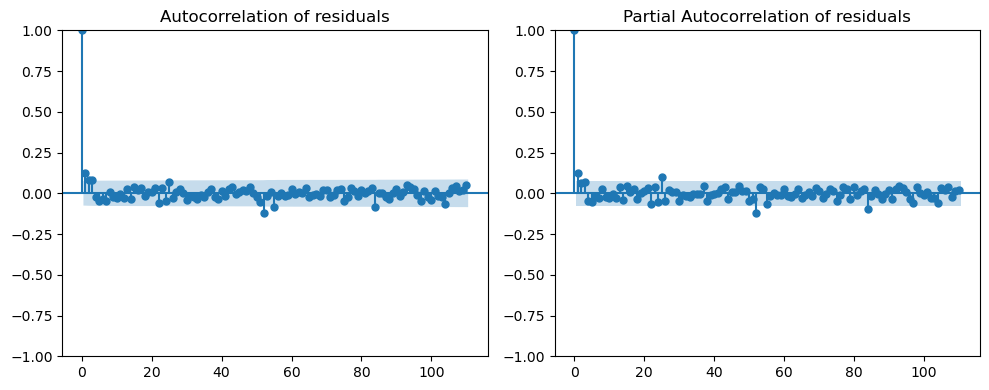

SARIMA(1,1,1,1,1,2,52) log 



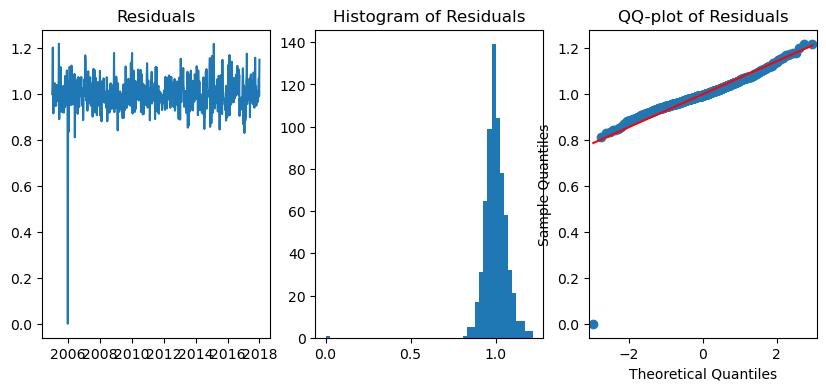

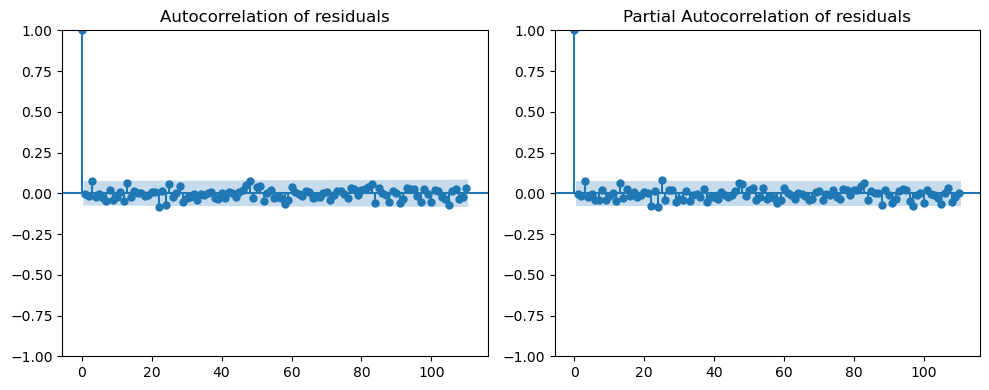

In [ ]:
for i in range(3):

    print(f'{model_names[i]} \n')

    resid = resid_list[i]

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")_

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(3):
    resid = resid_list[i]
    stap, p = shapiro(resid)
    p2 = jarque_bera(resid)
    print(f'P value testu SW dla modelu {model_names[i]} wynosi {p} \n')
    print(f'P value testu JB dla modelu {model_names[i]} wynosi {p2[1]} \n')

P value testu SW dla modelu SARIMA(0,1,2,0,1,2,52) wynosi 8.129484147389657e-28 

P value testu JB dla modelu SARIMA(0,1,2,0,1,2,52) wynosi 0.0 

P value testu SW dla modelu SARIMA(0,1,2,0,1,1,52) wynosi 1.6287637687931463e-27 

P value testu JB dla modelu SARIMA(0,1,2,0,1,1,52) wynosi 0.0 

P value testu SW dla modelu SARIMA(1,1,1,1,1,2,52) log wynosi 1.8574209569984875e-27 

P value testu JB dla modelu SARIMA(1,1,1,1,1,2,52) log wynosi 0.0 



Wykresy mogłyby sugerować, że reszty mają rozkład normalny, natomiast testy Shapiro-Wilka oraz Jarque-Bera (ten drugi oparty jest na skośności i kurtozie) odrzucają hipoteze zerową, która mówi że dane pochodzą z rozkładu normalnego. Prawdopodobnie czynnikiem jest większa kurtoza, gdyż reszty wyglądają symetrycznie.

Co do autokorelacji w resztach, w modelach opartych na danych nieztransformowanych widzimy jeszcze istotne statystycznie wartości - szczególnie przy wielokrotnościach 52. W modelu opartych na logarytmach reszty są nieskorelowane. Sugeruje nam to, że ten ostatni model może być lepszy.

Nastepnie rozważymy model Prophet, który będziemy traktować jako black-box. Pozwala on modelować sezonowości przy pomocy szeregów fouriera. Intepretacja parametrów (period, fourier order) jest następująca. Mamy rozwinięcie w szereg:

$s(t) = \sum_{n=1}^{k} \left( a_n \cos\left( \frac{2\pi n t}{T} \right) + b_n \sin\left( \frac{2\pi n t}{T} \right) \right)$

Gdzie $T$ to period a $k$ to fourier_order. Innymi słowy im większy fourier order tym więcej sinus i cosinus. Przyjmiemy $T = 1, 52$ oraz fourier_order $= 3, 5$.

In [ ]:
with open('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/models_p.pkl', "rb") as f:
    models_p = pickle.load(f)

Na koniec, przeprowadzimy ręczną dekompozycje szeregu na trend i sezonowość, a na podstawie tego przeprowadzimy prognozy. Do wyznaczenia komponenty trendu użyjemy regresji wielomianowej stopnia 3 a sezonowość wyestyujemy jako średnią wartość szeregu z odjętym trendem w danym tygodniu.

In [ ]:
df_ts = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_ts.pkl')

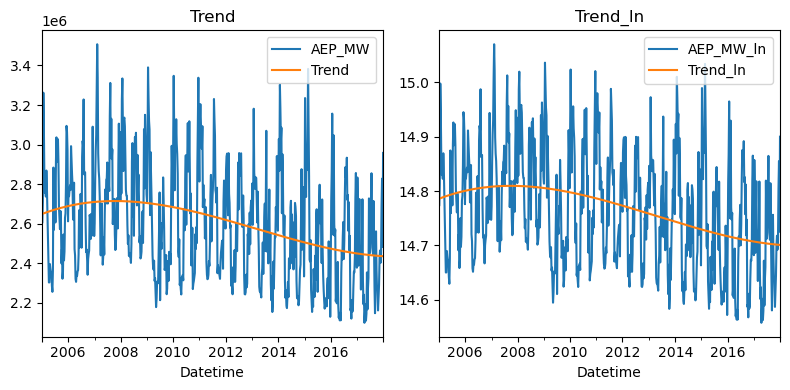

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend_ln")

plt.tight_layout()
plt.show()

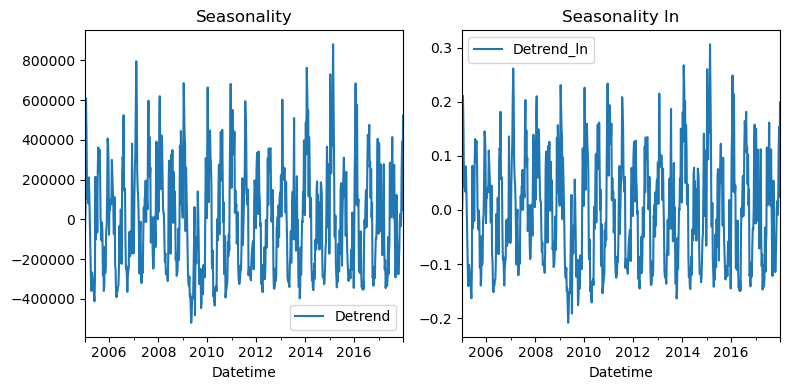

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

Mając już wybrane kilka modeli, które dopasowane zostały na zbiorze treningowym (dane do końca roku 2017) przeprowadzimy prognozy i policzymy błędy predykcji (na zbiorze testowym - pierwsze pół roku 2018). Metrykami, kórych użyjemy będą:

$L2 = \sum_n (| \hat{Y_n} - Y_n |^2)^{\frac{1}{2}}$,

$L2 = \sum_n (| \hat{Y_n} - Y_n |^3)^{\frac{1}{3}}$,

$AL2 = \sum_n (| w_n( \hat{Y_n} - Y_n) |^2)^{\frac{1}{2}}$,

$AL3 = \sum_n (| w_n(\hat{Y_n} - Y_n) |^3)^{\frac{1}{3}}$.

Gdzie $w_n = 1.1$ jeżeli $\hat{Y_n} - Y_n > 0$ i $w_n = 0.9$ w.p.p. Metryki te zostały wybrane ponieważ penalizują większe odchylenia mocniej (szczególnie te z $p = 3$) a ostatnie dwie metryki dodatkowo mocniej penalizują przeszacowaina prognozy.

In [ ]:
df_pred = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_pred.pkl')

In [ ]:
df_pred.columns = ['Wartość prawdziwa', 'SARIMA 1', 'SARIMA 2', 'SARIMA log', 'Prophet', 'Prophet log', 'Regresja i sezonowość', 'Regresja i sezonowość log']

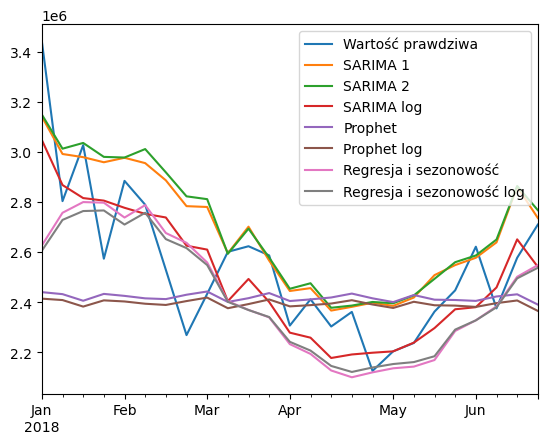

In [ ]:
df_pred.plot()
plt.show()

Na wykresie wydaje się, że model SARIMA zbudowany na danych zlogarytmowanych najlepiej prognozuje prawdziwe wartości. Potwierdzimy to porównując w.w. metryki

In [ ]:
df_err = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_err.pkl')
df_err.index = df_pred.columns[1:]

In [ ]:
df_err

,L2,L3,AL2,AL3
SARIMA 1,1087033.150815,737583.826561,1179715.177865,802903.583109
SARIMA 2,1154087.609588,784883.127264,1255718.236227,856562.108433
SARIMA log,864355.296006,577523.643279,846349.463371,569912.805489
Prophet,1551437.403957,1160285.04121,1427201.240137,1052694.006581
Prophet log,1603648.243575,1197454.605692,1465737.391883,1083232.141682
Regresja i sezonowość,1214643.156243,904120.880231,1133261.70776,833336.662269
Regresja i sezonowość log,1213883.757495,915935.490263,1126081.595026,839551.224667


Faktycznie, model logarytmiczny ma najmniejsze błędy prognozy względem wszystkich metryk. Prawdopodobnie poradził sobie lepiej od innych z racji na lepsze uchwycenie dynamiki zmian między okresami. Kolejnym najlepszym modelem jest SARIMA zbudowana na danych niezlogarytmowanych z parametrami $(0, 1, 2, 0, 1, 2, 52)$

In [ ]:
dfo = pd.read_csv("AEP_hourly.csv")

In [ ]:
dfo.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [ ]:
dfo["Datetime"] = pd.to_datetime(dfo["Datetime"])

In [ ]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='D')).sum()

# Agregacja dzienna

In [ ]:
df.sort_index(inplace = True)

In [ ]:
df = df.iloc[:-1] # Ostatni dzień jest niepełny, odrzucamy go, aby nie zaburzał nam wykresów

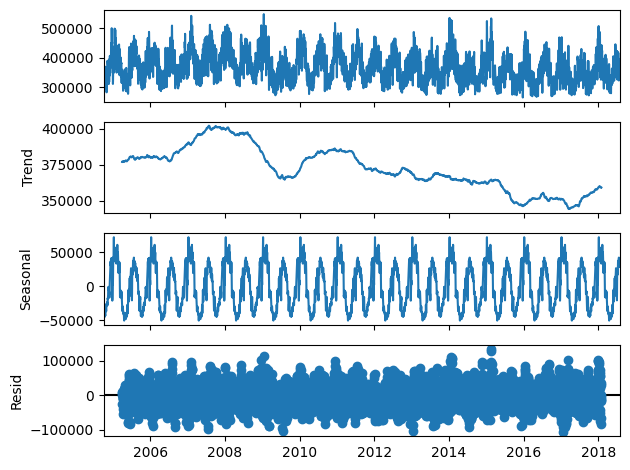

In [ ]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 365)
decomp_a.plot()
plt.show()

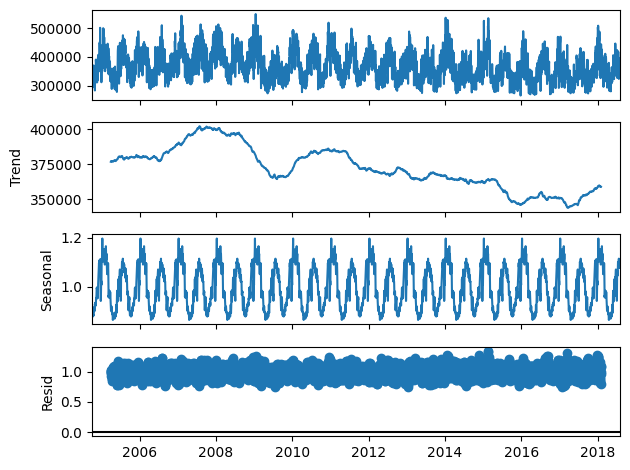

In [ ]:
decomp_am = seasonal_decompose(df, model = 'multiplicative', period = 365)
decomp_am.plot()
plt.show()

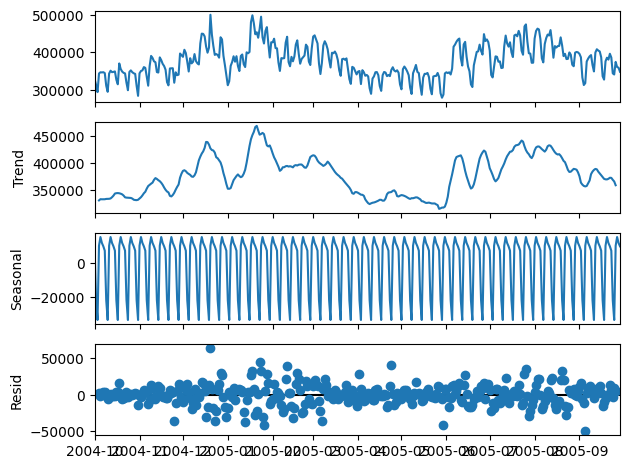

In [ ]:
decomp_b = seasonal_decompose(df[:364], model = 'additive', period = 7)
decomp_b.plot()
plt.show()

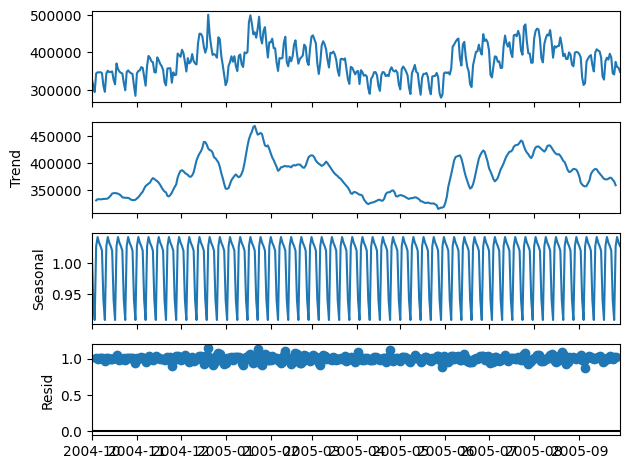

In [ ]:
decomp_bm = seasonal_decompose(df[:364], model = 'multiplicative', period = 7)
decomp_bm.plot()
plt.show()

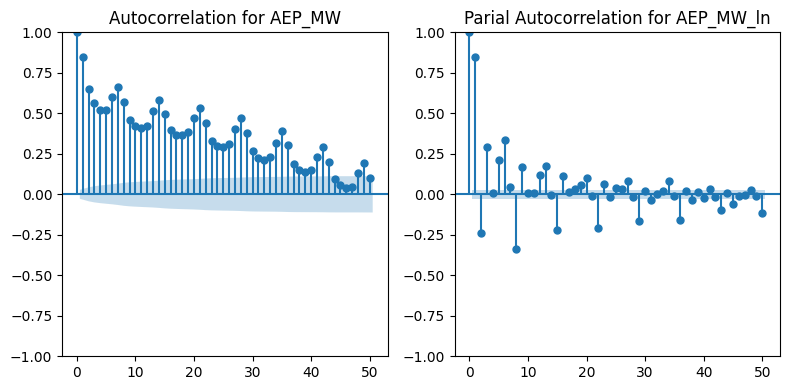

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=50, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

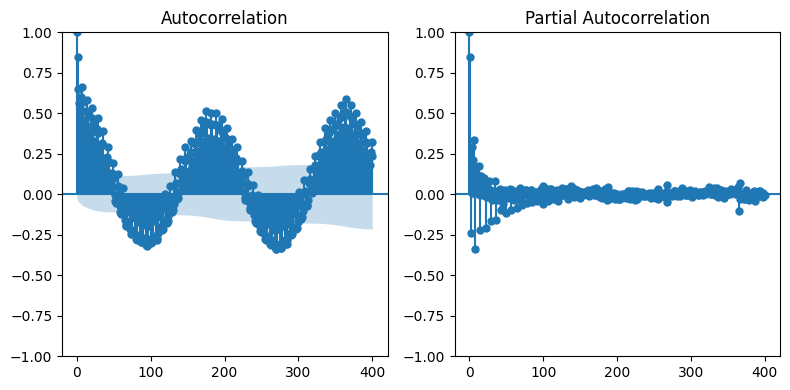

In [ ]:
fig2, axes2 = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=400, ax=axes2[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=400, ax=axes2[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Po zagregowaniu danych według dnia widać, że w danych występują dwie osobne sezonowości: sezonowość tygodniowa oraz sezonowość roczna. Podobnie jak w przypadku agregacji tygodniowej, wartość cząstkowej autokorelacji jest największa przy pierwszym opóźnieniu.

W następnej fazie spróbujemy dokonać dekompozycji tego szeregu ręcznie. Dokonamy tego na dwa sposoby - raz, szukając sezonowości tygodniowej, a drugi raz, szukając sezonowości rocznej.

In [ ]:
df.head()

,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


In [ ]:
df.tail()

,AEP_MW
Datetime,
2018-07-29,327792.0
2018-07-30,368834.0
2018-07-31,364327.0
2018-08-01,363628.0
2018-08-02,376504.0


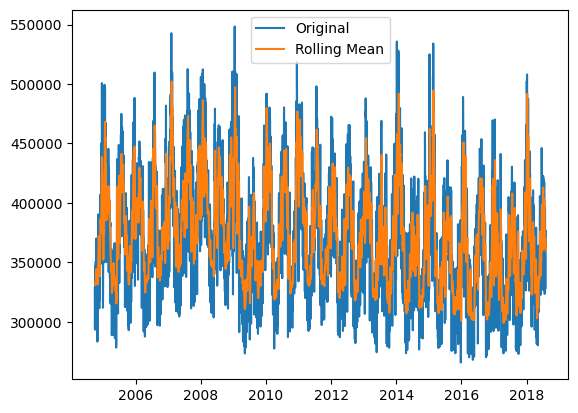

In [ ]:
df_ma7 = df.rolling(window = 7).mean()
plt.plot(df, label = 'Original')
plt.plot(df_ma7, label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

Poniżej możemy porównać kilka różnych lat z badanego okresu po zastosowaniu uśrednienia na tygodniach. Na wykresie wyraźnie widać sezonowość na przestrzeni roku - zużycie energii jest zdecydowanie największe w zimie i w lecie, a mniejsze na wiosnę i na jesień.

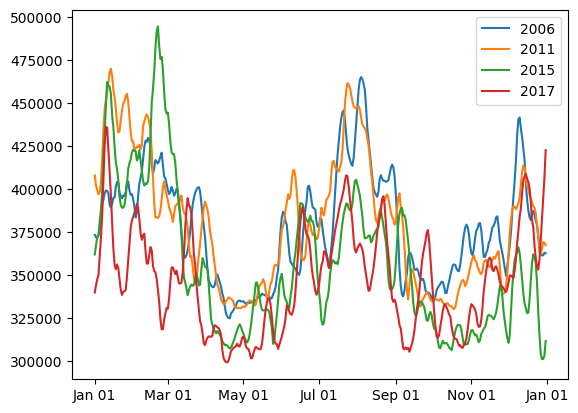

In [ ]:
years = ["2006", "2011", "2015", "2017"]
for year in years:
    dfl = df_ma7.loc[year]
    plt.plot(pd.to_datetime(dfl.index.dayofyear, format='%j', yearfirst=True), dfl, label = year)
plt.legend(loc = 'best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

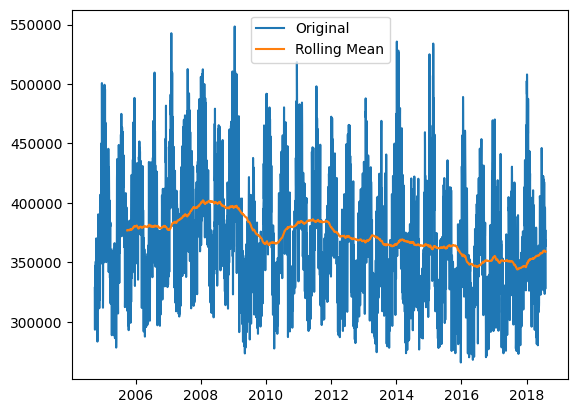

In [ ]:
df_ma365 = df.rolling(window = 365).mean()
plt.plot(df, label = 'Original')
plt.plot(df_ma365, label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

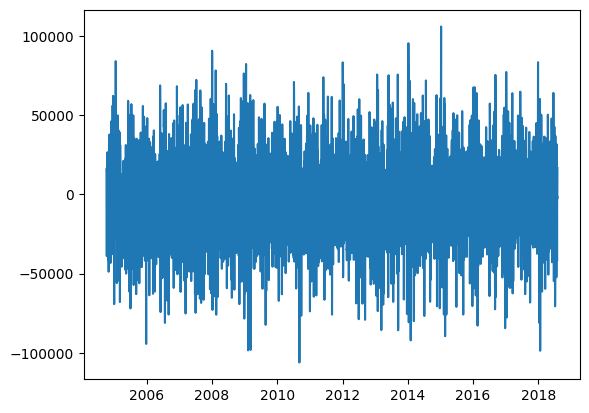

In [ ]:
df_no7trend = df - df_ma7
df_no7trend.dropna(inplace = True)
plt.plot(df_no7trend)
plt.show()

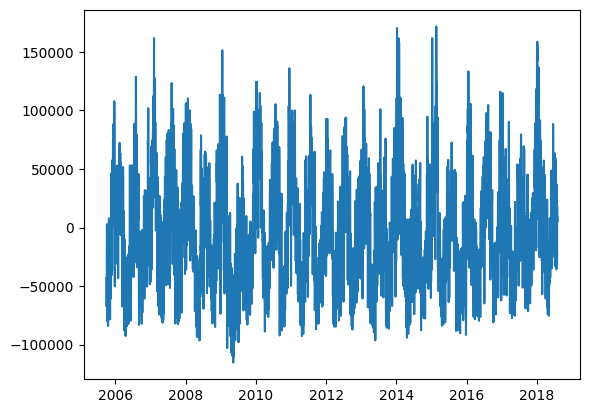

In [ ]:
df_no365trend = df - df_ma365
df_no365trend.dropna(inplace = True)
plt.plot(df_no365trend)
plt.show()

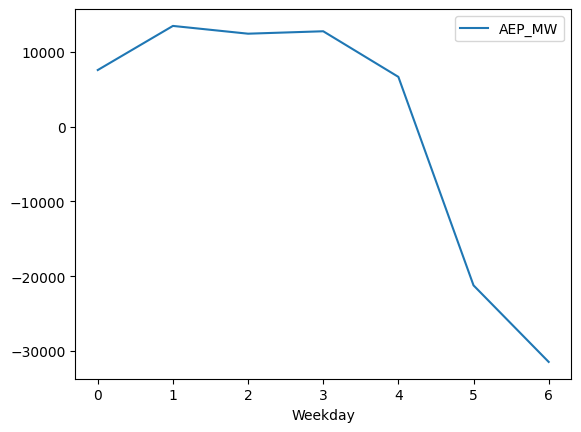

In [ ]:
df_no7trend['Weekday'] = df_no7trend.index.weekday
weekly_avg = df_no7trend.groupby('Weekday').mean()
weekly_avg.plot()
plt.show()

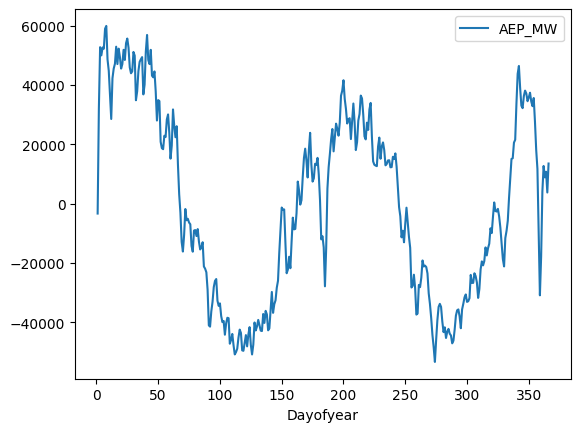

In [ ]:
df_no365trend['Dayofyear'] = df_no365trend.index.dayofyear
yearly_avg = df_no365trend.groupby('Dayofyear').mean()
yearly_avg.plot()
plt.show()

In [ ]:
weekly_avg

,AEP_MW
Weekday,
0,7554.605508
1,13452.078264
2,12413.306519
3,12738.256035
4,6640.297206
5,-21229.777293
6,-31463.829998


In [ ]:
df_no7trend = pd.merge(df_no7trend, weekly_avg, how = 'left', left_on = 'Weekday', right_index = True)

In [ ]:
df_no7trend.rename(columns = {'AEP_MW_x':'AEP_MW', 'AEP_MW_y':'Weekly_Avg'}, inplace = True)

In [ ]:
df_no7trend.head(n = 14)

,AEP_MW,Weekday,Weekly_Avg
Datetime,,,
2004-10-07,15794.285714,3,12738.256035
2004-10-08,11150.000000,4,6640.297206
2004-10-09,-22605.000000,5,-21229.777293
2004-10-10,-38899.142857,6,-31463.829998
2004-10-11,10077.714286,0,7554.605508
2004-10-12,17041.000000,1,13452.078264
2004-10-13,13087.428571,2,12413.306519
2004-10-14,13678.857143,3,12738.256035
2004-10-15,14304.857143,4,6640.297206


In [ ]:
df_no365trend = pd.merge(df_no365trend, yearly_avg, how = 'left', left_on = 'Dayofyear', right_index = True)

In [ ]:
df_no365trend.rename(columns = {'AEP_MW_x':'AEP_MW', 'AEP_MW_y':'Yearly_Avg'}, inplace = True)

In [ ]:
df_no365trend.head(10)

,AEP_MW,Dayofyear,Yearly_Avg
Datetime,,,
2005-09-30,-43213.879452,273,-48299.245100
2005-10-01,-67543.035616,274,-53310.624025
2005-10-02,-61842.167123,275,-45938.874605
2005-10-03,-1113.112329,276,-39279.298630
2005-10-04,2800.841096,277,-34776.893361
2005-10-05,493.473973,278,-33746.890832
2005-10-06,-607.087671,279,-34779.327503
2005-10-07,-26139.112329,280,-39676.734668
2005-10-08,-63807.219178,281,-43276.831823


In [ ]:
df_no7trend['Noise'] = df_no7trend['AEP_MW'] - df_no7trend['Weekly_Avg']
df_no365trend['Noise'] = df_no365trend['AEP_MW'] - df_no365trend['Yearly_Avg']

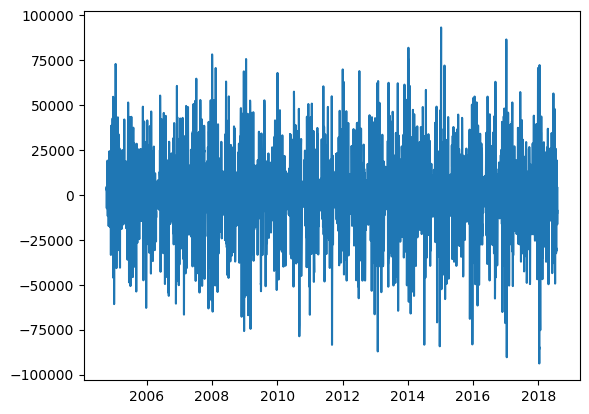

In [ ]:
plt.plot(df_no7trend['Noise'])
plt.show()

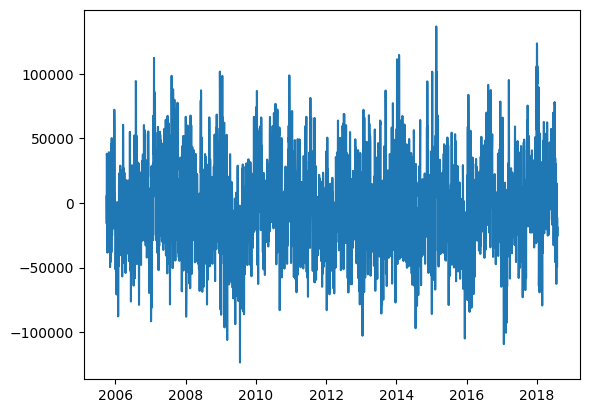

In [ ]:
plt.plot(df_no365trend['Noise'])
plt.show()

Możemy zauważyć, że po usunięciu z danych sezonowości tygodniowej nadal widoczna jest sezonowość roczna i vice versa. Niestety wyciągnięcie obu tych sezonowości naraz wydaje się trudne, ponieważ się na siebie nakładają, i zwykłe odjęcie obu sezonowości zaburzyłoby nam poprawną interpretację komponentu "noise".

W dalszym ciągu dokonujemy analizy podobnej do tej, którą stosowaliśmy przy agregacji tygodniowej. Dokonamy zróżnicowania co 7 i co 365 dni, aby usunąć trend na przestrzeni tygodnia i roku, dodatkowo będziemy też badać logarytmy naszych danych. Będziemy próbowali dopasować modele do danych oraz zobaczymy, co się stanie, jeśli będziemy próbowali dopasować model wyłącznie do sezonowości tygodniowej bez uwzględnienia sezonowości rocznej.

In [ ]:
df['AEP_MW_ln'] = np.log(df['AEP_MW'])

In [ ]:
dfd = df.diff(7).diff(365)
dfd = dfd.dropna()

In [ ]:
dfd.head()

,AEP_MW,AEP_MW_ln
Datetime,,
2005-10-08,-11698.0,-0.033775
2005-10-09,-16337.0,-0.053489
2005-10-10,-34710.0,-0.097258
2005-10-11,-32950.0,-0.090712
2005-10-12,-34679.0,-0.096182


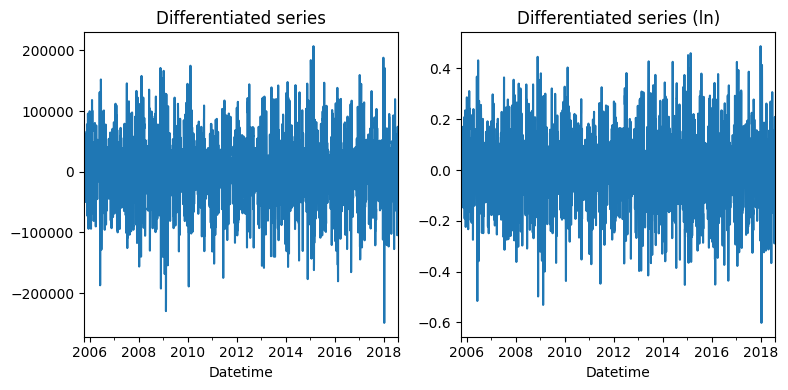

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0])
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

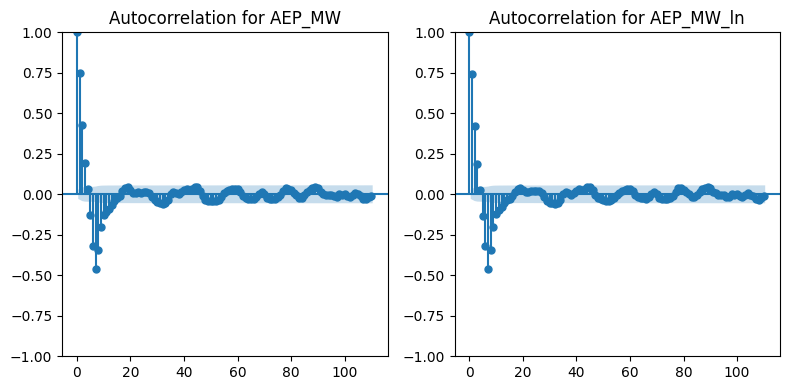

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

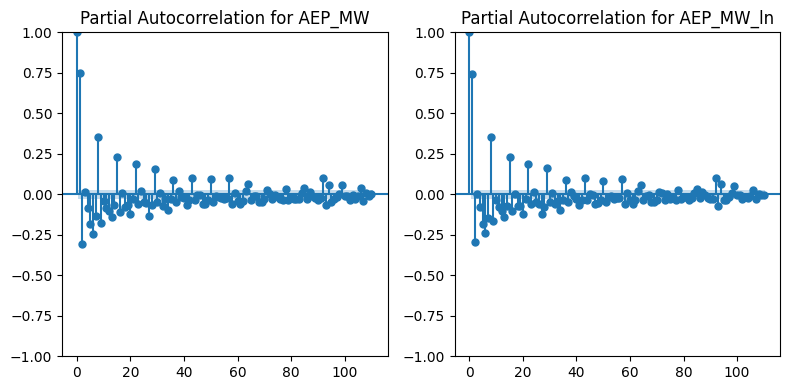

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

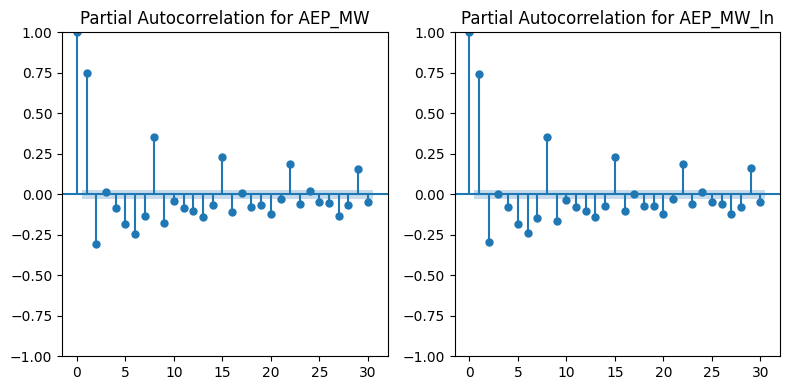

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=30, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Można zaobserwować, że funkcja PACF mocno się wybija dla n = 7k + 1. Podejrzewam, że ma to związek albo z latami przestępnymi, albo z faktem, że 365 daje resztę 1 z dzielenia przez 7 (co oznacza, że jak zrobimy diff(365) to dni tygodnia z kolejnych lat będą przesunięte względem siebie o 1).

In [ ]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-wartość dla pierwotnego szeregu po zróżnicowaniu to {adt1[1]}, a p-wartość dla logarytmu tego szeregu i zróżnicowaniu to {adt2[1]}")
print("Tak zróżnicowane szeregi są stacjonarne.")

p-wartość dla pierwotnego szeregu po zróżnicowaniu to 7.091863711796819e-30, a p-wartość dla logarytmu tego szeregu i zróżnicowaniu to 7.659768939135218e-30
Tak zróżnicowane szeregi są stacjonarne.


Dostajemy potwierdzenie, że po zróżnicowaniu możemy traktować szeregi jako stacjonarne.

W następnym kroku spróbujemy dopasować model SARIMA do szeregu zagregowanego po dniu. Niestety, dopasowanie do okresu 365 dni (rok) nie jest możliwe dla mocy obliczeniowej, którą dysponujemy. Daje nam to jednak ciekawą okazję do tego, aby dopasować model do sezonowości tygodniowej, ignorując sezonowość roczną i zobaczyć, jaki będzie efekt.

In [ ]:
combinations = list(itertools.product([0, 1, 2], repeat=4))
matrix = np.array(combinations)
dfL = pd.DataFrame(matrix, columns = ['p', 'q', 'P', 'Q'])
dfL.drop(0, inplace = True)
dfL['AIC'] = 0
dfL['BIC'] = 0

dfL2 = dfL.copy()

In [ ]:
data_train = df.loc['2005-01-01':'2017-12-31', :]
data_test = df.loc['2018-01-01':'2018-06-30', :]

In [ ]:
# for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 7))
#     model = model.fit()
#     dfL.loc[i, 'AIC'] = model.aic
#     dfL.loc[i, 'BIC'] = model.bic
# for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 7))
#     model = model.fit()
#     dfL2.loc[i, 'AIC'] = model.aic
#     dfL2.loc[i, 'BIC'] = model.bic

# dfL.to_pickle("dfL.pkl")
# dfL2.to_pickle("dfL2.pkl")

In [ ]:
# for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 365))
#     model = model.fit()
#     dfL.loc[i, 'AIC'] = model.aic
#     dfL.loc[i, 'BIC'] = model.bic
# for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 365))
#     model = model.fit()
#     dfL2.loc[i, 'AIC'] = model.aic
#     dfL2.loc[i, 'BIC'] = model.bic

# dfL.to_pickle("dfL3.pkl")
# dfL2.to_pickle("dfL4.pkl")

# Niestety wyliczenie SARIMA dla okresu 365 dni zdecydowanie przekracza możliwości obliczeniowe

In [ ]:
dfL = pd.read_pickle("dfL.pkl")
dfL2 = pd.read_pickle("dfL2.pkl")

In [ ]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])

df_IC.reset_index(drop = True, inplace= True)
df_IC

,p,q,P,Q,AIC,BIC
0,2,1,0,1,105930.241197,105962.560159
1,2,1,0,1,105930.241197,105962.560159
2,2,2,1,2,106844.254360,106895.964699
3,2,2,1,2,106844.254360,106895.964699


Tym razem otrzymujemy zupełnie inne modele niż te, które dostaliśmy przy agregacji tygodniowej. Niewątpliwie wynika to z faktu, że dopasowujemy go do innej sezonowości. Przekonamy się jeszcze, jak dobrze te modele odpowiadają rzeczywistości.

In [ ]:
models = []
for i in range(3):
    if i < 2:
        model = SARIMAX(data_train['AEP_MW'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 7))
    else:
        model = SARIMAX(data_train['AEP_MW_ln'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 7))
    models.append(model.fit())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model nr 0


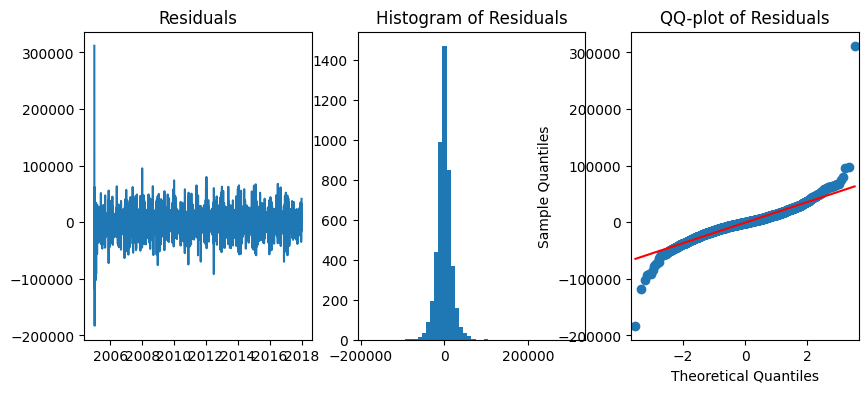

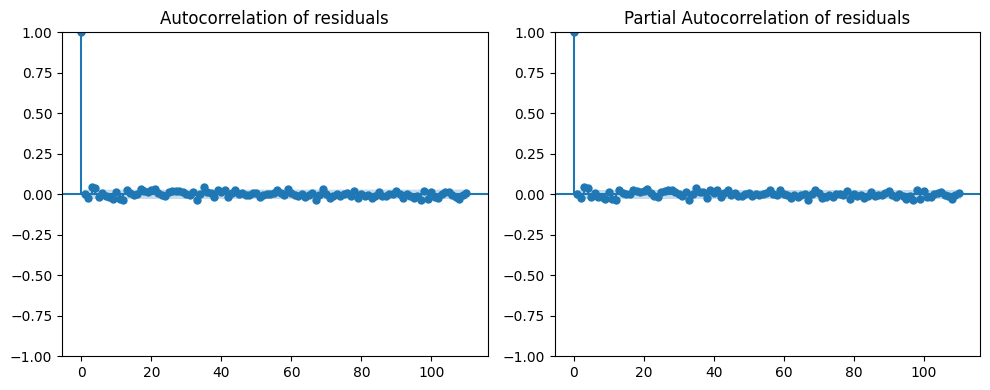

Model nr 1


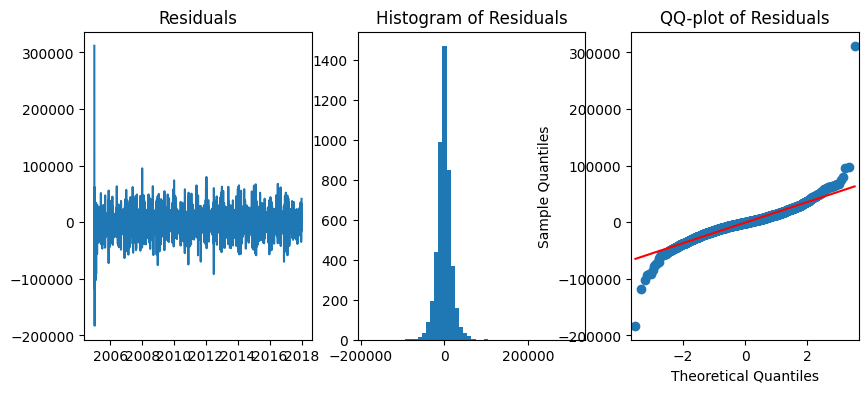

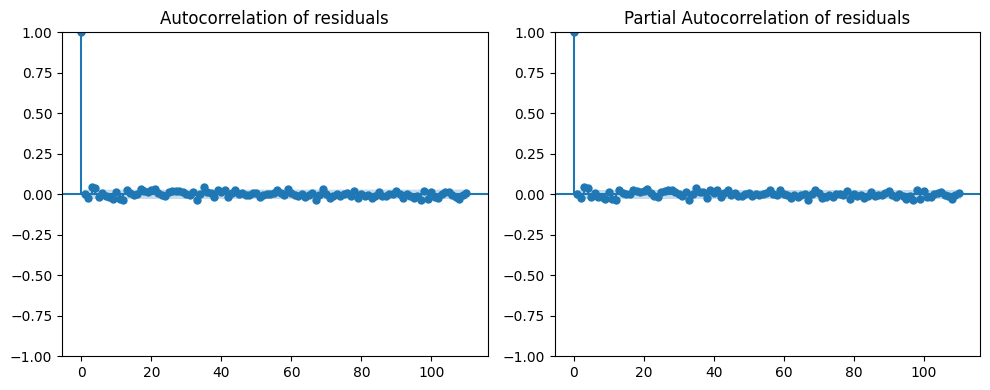

Model nr 2


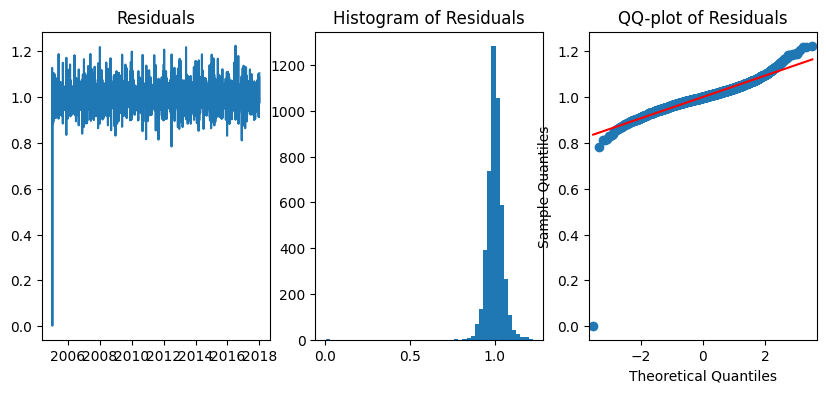

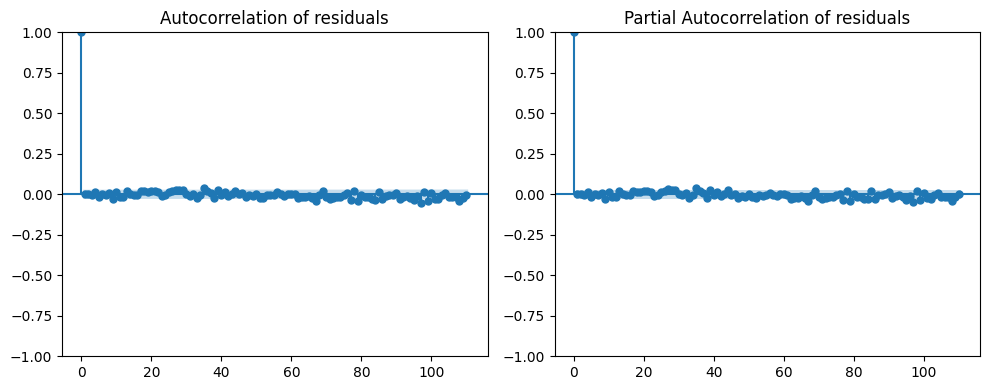

In [ ]:
resid_list = []

for i in range(3):

    print(f'Model nr {i}')
    model_fit = models[i]

    if i < 2:
        resid = model_fit.resid
    else:
        resid = np.exp(model_fit.resid[1:])

    resid_list.append(resid)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")

    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['SARIMA(2,1,1,0,1,1,7)', 'SARIMA(2,1,1,0,1,1,7)', 'SARIMA(2,1,2,1,1,2,7)']

In [ ]:
for i in range(3):
    resid = resid_list[i]
    stap, p = shapiro(resid)
    p2 = jarque_bera(resid)
    print(f'P value testu SW dla modelu {model_names[i]} wynosi {p} \n')
    print(f'P value testu JB dla modelu {model_names[i]} wynosi {p2[1]} \n')

P value testu SW dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 1.2969208958145409e-44 

P value testu JB dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 0.0 

P value testu SW dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 1.2969208958145409e-44 

P value testu JB dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 0.0 

P value testu SW dla modelu SARIMA(2,1,2,1,1,2,7) wynosi 4.000063944339407e-46 

P value testu JB dla modelu SARIMA(2,1,2,1,1,2,7) wynosi 0.0 



Chociaż ponownie reszty na wykresach wyglądają na pochodzące z rozkładu normalnego, to testy statystyczne twierdzą, że tak nie jest. W tym przypadku prawdopodobnym czynnikiem wpływającym na to jest fakt, że modele są dopasowane do sezonowości tygodniowej, ale nie uwzględniają sezonowości rocznej, która ma nadal wpływ na to, jak wyglądają reszty.

In [ ]:
df_pred = data_test[['AEP_MW']].copy()

In [ ]:
for i in range(3):
    model_fit = models[i]
    pred = model_fit.predict(start = '2018-01-07', end = '2018-06-24')
    if i < 2:
        df_pred[f'Pred no {i}'] = pred
    else:
        df_pred[f'Pred no {i}'] = np.exp(pred)

In [ ]:
dfp1 = data_train[['AEP_MW']].copy()
dfp2 = data_train[['AEP_MW_ln']].copy()
dfp1.reset_index(inplace = True)
dfp2.reset_index(inplace = True)
dfp1.columns = ['ds', 'y']
dfp2.columns = ['ds', 'y']

In [ ]:
modelp1 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)
modelp2 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)

In [ ]:
modelp1.add_seasonality(name='yearly', period=365, fourier_order=5)
modelp1.add_seasonality(name='weekly', period=7, fourier_order=3)

modelp2.add_seasonality(name='yearly', period=365, fourier_order=5)
modelp2.add_seasonality(name='weekly', period=7, fourier_order=3)

In [ ]:
modelp_fit1 = modelp1.fit(dfp1)
modelp_fit2 = modelp2.fit(dfp2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/q8grfymh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/k8x974e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22988', 'data', 'file=/tmp/tmp96hd8b9f/q8grfymh.json', 'init=/tmp/tmp96hd8b9f/k8x974e1.json', 'output', 'file=/tmp/tmp96hd8b9f/prophet_model6xzmtorb/prophet_model-20250131220340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/7o_1y_f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/0asbyvp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
future = modelp_fit1.make_future_dataframe(periods=185, freq = 'D')

In [ ]:
predp1 = modelp_fit1.predict(future)[['ds', 'yhat']]
predp2 = modelp_fit2.predict(future)[['ds', 'yhat']]

In [ ]:
df_pred = df_pred.merge(predp1.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 3'}, axis =1, inplace = True)

In [ ]:
df_pred = df_pred.merge(predp2.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 4'}, axis =1, inplace = True)

In [ ]:
df_pred['Pred no 4'] = np.exp(df_pred['Pred no 4'])

In [ ]:
df_ts = data_train.copy()

In [ ]:
vals_x = np.arange(len(df_ts))
vals_y1 = df_ts[['AEP_MW']].values
vals_y2 = df_ts[['AEP_MW_ln']].values

In [ ]:
poly = PolynomialFeatures(degree=3)
vals_x_poly = poly.fit_transform(vals_x.reshape(-1, 1))

In [ ]:
model_poly1 = LinearRegression().fit(vals_x_poly, vals_y1)
model_poly2 = LinearRegression().fit(vals_x_poly, vals_y2)

In [ ]:
df_ts['Trend'] = model_poly1.predict(vals_x_poly)
df_ts['Trend_ln'] = model_poly2.predict(vals_x_poly)

In [ ]:
df_ts['Detrend'] = df_ts['AEP_MW'] - df_ts['Trend']
df_ts['Detrend_ln'] = df_ts['AEP_MW_ln'] - df_ts['Trend_ln']

In [ ]:
df_ts = df_ts.loc[df_ts['Trend'].notna(), :]
df_ts = df_ts.loc[df_ts.index.year > 2004]

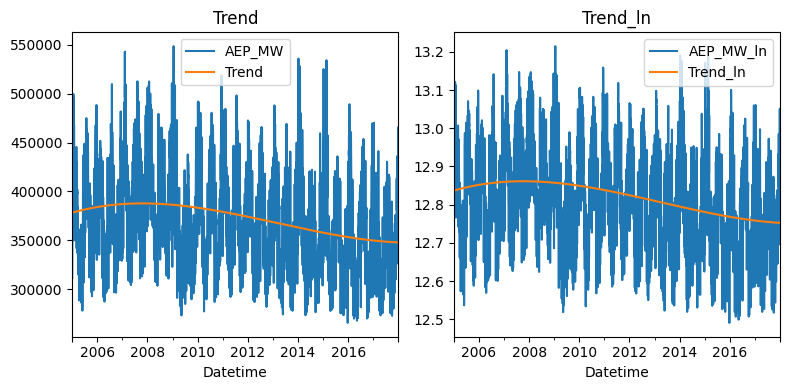

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend_ln")

plt.tight_layout()
plt.show()

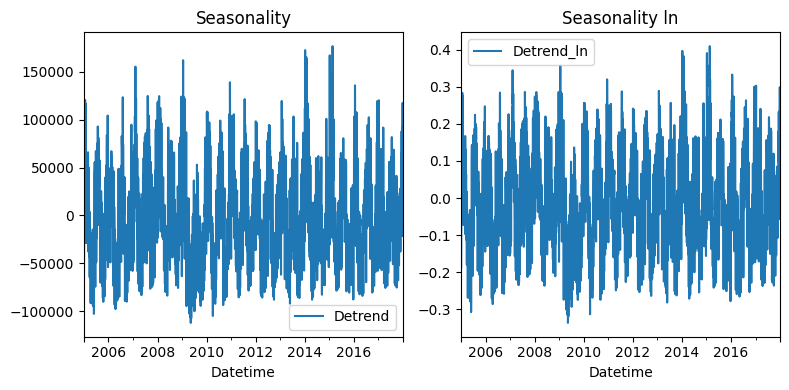

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

In [ ]:
df_ts['Day no'] = np.nan
curr_year = df_ts.index[0].year
i = 1
for j in df_ts.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts.loc[j, 'Day no'] = i
        curr_year = next_year
    else:
        df_ts.loc[j, 'Day no'] = i
        i = i + 1

In [ ]:
df_ts = df_ts.reset_index().merge(df_ts[['Day no', 'Detrend', 'Detrend_ln']].reset_index(drop = True).groupby('Day no').mean().rename({'Detrend':'Seasonality', 'Detrend_ln':'Seasonality_ln'}, axis = 1), left_on = 'Day no', right_on = 'Day no')

df_ts = df_ts.set_index('Datetime').sort_index()

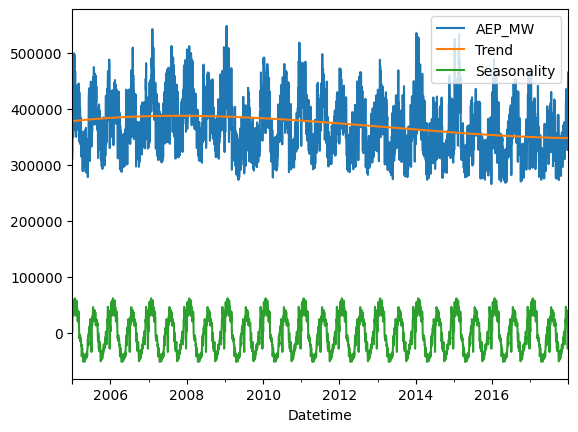

In [ ]:
df_ts[['AEP_MW', 'Trend', 'Seasonality']].plot()
plt.show()

In [ ]:
df_ts_pred = data_test.copy()
df_ts_pred['Day no'] = np.nan
curr_year = df_ts_pred.index[0].year
i = 1
for j in df_ts_pred.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts_pred.loc[j, 'Day no'] = i
        curr_year = next_year
    else:
        df_ts_pred.loc[j, 'Day no'] = i
        i = i + 1

In [ ]:
df_ts_pred = df_ts_pred.reset_index().merge(df_ts[['Day no', 'Seasonality', 'Seasonality_ln']].head(181), left_on = 'Day no', right_on = 'Day no', how = 'left')

vals_x_p = np.arange(vals_x[-1] + 1, vals_x[-1] + 182)

In [ ]:
vals_x_poly_p = poly.fit_transform(vals_x_p.reshape(-1, 1))

In [ ]:
df_ts_pred['Trend'] = model_poly1.predict(vals_x_poly_p)
df_ts_pred['Trend_ln'] = model_poly2.predict(vals_x_poly_p)

In [ ]:
df_ts_pred['Pred'] = df_ts_pred['Trend'] + df_ts_pred['Seasonality']
df_ts_pred['Pred_ln'] = df_ts_pred['Trend_ln'] + df_ts_pred['Seasonality_ln']

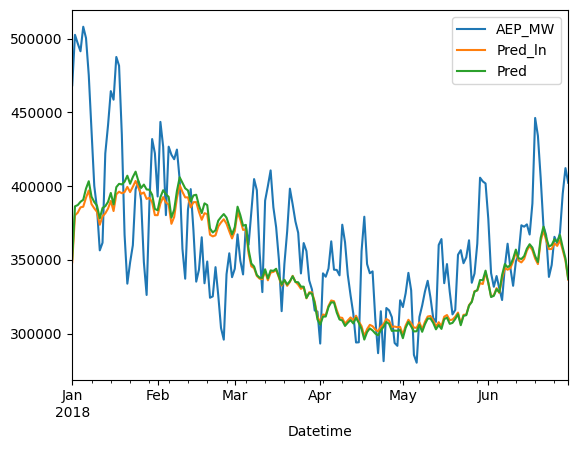

In [ ]:
df_ts_pred.set_index('Datetime', inplace =  True)
df_ts_pred['Pred_ln'] = np.exp(df_ts_pred['Pred_ln'])
df_ts_pred[['AEP_MW','Pred_ln', 'Pred']].plot()
plt.show()

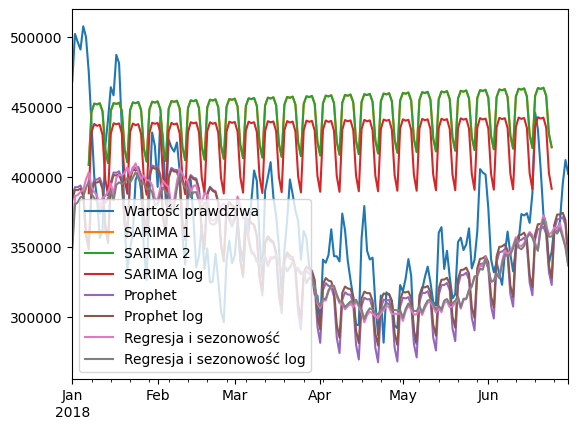

In [ ]:
df_ts_pred.rename({'Pred':'Pred no 5', 'Pred_ln':'Pred no 6'}, axis = 1, inplace = True)
df_pred = df_pred.merge(df_ts_pred[['Pred no 5', 'Pred no 6']], left_index = True, right_index = True)

df_pred.columns = ['Wartość prawdziwa', 'SARIMA 1', 'SARIMA 2', 'SARIMA log', 'Prophet', 'Prophet log', 'Regresja i sezonowość', 'Regresja i sezonowość log']

df_pred.plot()
plt.show()

Jak widać na wykresie, SARIMA zbudowana na okresie 7 dni nie jest odpowiednim modelem do przewidywania potrzebnej energii - ignoruje ona kompletnie sezonowość roczną i uwzględnia tylko (niewiele znaczący) trend, a tak się składa, że w naszych danych sezonowość roczna wyraźnie dominuje nad sezonowością tygodniową pod względem amplitudy. Można się zastanawiać, jak SARIMA by sobie poradziła, gdyby była zbudowana na okresie 365 dni - pewne porównanie mamy w przypadku agregacji tygodniowej, ale w przypadku agregacji dziennej brakuje mocy obliczeniowej, aby zbudować odpowiedni model.

Pozostałe modele uwzględniają sezonowość roczną razem z sezonowością tygodniową i dużo lepiej dopasowują się do rzeczywistych wartości. Można zauważyć, że model zbudowany przez Propheta bardzo ściśle przestrzega sezonowości tygodniowej, a model powstały z regresji jest dużo bardziej uśredniony. Możemy porównać błędy tych modeli, aby się przekonać, które z nich są faktycznie lepsze.

Błędy będziemy liczyć z takich samych wzorów, jak przy agregacji tygodniowej.

In [ ]:
for i in range(1,8):
    err = df_pred['Wartość prawdziwa'] - df_pred[df_pred.columns[i]]
    df_pred[f'Err no {i}'] = err
df_err = pd.DataFrame(index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7'],columns = ['L2', 'L3', 'AL2', 'AL3'])

LP2 = ((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**2).sum(axis = 0))**(1/2)
LP3 = (np.abs(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**3).sum(axis = 0))**(1/3)
ALP2 = (((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**2).sum(axis = 0))**(1/2)
ALP3 = (np.abs((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**3).sum(axis = 0))**(1/3)

df_err.loc[:, 'L2'] = LP2.values
df_err.loc[:, 'L3'] = LP3.values
df_err.loc[:, 'AL2'] = ALP2.values
df_err.loc[:, 'AL3'] = ALP3.values

15

In [ ]:
df_err

,L2,L3,AL2,AL3
Model 1,1246351.453808,557871.907303,1369846.218961,613447.056411
Model 2,1246351.453808,557871.907303,1369846.218961,613447.056411
Model 3,1008992.698572,458056.846917,1106647.884185,502988.458064
Model 4,554443.297601,279824.634702,517397.981444,258737.572416
Model 5,534859.735179,276841.217871,499566.706673,255761.899421
Model 6,568106.476817,282009.492004,537048.584021,264818.903379
Model 7,570896.023522,286388.112051,535074.180548,266034.86343


Według obliczonych błędów model Propheta jest minimalnie lepszy niż model regresji liniowej, a oba są dużo lepsze niż modele SARIMA z okresem 7. Modele te mają też wyraźnie mniejszy błąd niż modele w agregacji tygodniowej - co prawdopodobnie wynika z większej dokładności, z jaką mogliśmy zbudować te modele, dzięki czemu lepiej uchwyciliśmy sezonowości, którym te dane podlegają.